AC/DC/SOC-OPF Data
---
This notebook is distributed alongside data that was generated using the AI4OPT/OPFGenerator repository. The data consists of several HDF5 files which contain input/solution data, and a JSON file which contains network information.

In the cell below, input the path to the directory containing the data files and the network name (the prefix of the data files).

In [15]:
data_folder = "data/" # path to the folder containing the data files
case_ref = "14_ieee" # 5_pjm or 14_ieee

Then, install `h5py` to parse the data files.

In [16]:
%pip install h5py

Note: you may need to restart the kernel to use updated packages.


### Parsing functions

The next few cells define functions used for parsing the data.

In [17]:
import h5py
import numpy as np


def parse_hdf5(path, preserve_shape=False):
    """Parse an HDF5 file into a dictionary.

    If `preserve_shape` is `True`, the dictionary will be structured
    to reflect the original structure of the HDF5 file. Otherwise, the
    dictionary will be flat where the keys are the paths to the data
    in the HDF5 file, e.g. d["primal"]["pg"] is under d["primal/pg"].

    Args:
        path (str): Path to the HDF5 file.
        preserve_shape (bool, optional): Whether to preserve the shape of the data. Defaults to False.

    Returns:
        dict: Dictionary containing the data from the HDF5 file.
    """
    dat = dict()

    def read_direct(dataset: h5py.Dataset):
        arr = np.empty(dataset.shape, dtype=dataset.dtype)

        if set(dataset.shape) != {0}:
            dataset.read_direct(arr)

        if arr.dtype.kind in "SO":
            return arr.astype(str)
        else:
            return arr

    def store(name, obj):
        if isinstance(obj, h5py.Group):
            return
        elif isinstance(obj, h5py.Dataset):
            dat[name] = read_direct(obj)
        else:
            raise ValueError(f"Got {type(obj)} under {name}.")

    with h5py.File(path, "r") as f:
        f.visititems(store)

    if preserve_shape:
        # recursively correct the shape of the dictionary
        ret = dict()

        def r_correct_shape(d: dict, ret: dict):
            for k in list(d.keys()):
                if "/" in k:
                    k1, k2 = k.split("/", 1)
                    if k1 not in ret:
                        ret[k1] = dict()
                    r_correct_shape({k2: d[k]}, ret[k1])
                    del d[k]
                else:
                    ret[k] = d[k]

        r_correct_shape(dat, ret)

        return ret
    else:
        return dat


In [18]:
import json

from collections import defaultdict

@staticmethod
def pad_to_dense(array, padval):
    """from https://codereview.stackexchange.com/questions/222623/pad-a-ragged-multidimensional-array-to-rectangular-shape"""

    def iterate_nested_array(array, index=()):
        try:
            for idx, row in enumerate(array):
                yield from iterate_nested_array(row, (*index, idx))
        except TypeError:  # final level
            yield (*index, slice(len(array))), array

    def get_max_shape(array):
        def get_dimensions(array, level=0):
            yield level, len(array)
            try:
                for row in array:
                    yield from get_dimensions(row, level + 1)
            except TypeError:  # not an iterable
                pass

        dimensions = defaultdict(int)
        for level, length in get_dimensions(array):
            dimensions[level] = max(dimensions[level], length)
        return [value for _, value in sorted(dimensions.items())]

    dimensions = get_max_shape(array)
    result = np.full(dimensions, padval)
    for index, value in iterate_nested_array(array):
        result[index] = np.array(value)
    return result

def parse_json(path, model_type=["ACOPF", "DCOPF", "SOCWRConic"]):
    """Parse the JSON file from OPFGenerator.

    Args:
        path (str)
            Path to the JSON file.
        model_type (Union[str, Sequence[str]])
            The reference solutions to save. Default: ["ACOPF", "DCOPF", "SOCWRConic"].
            If any of the models are not found in the JSON file, a warning will be printed.

    Returns:
        dict: Dictionary containing the parsed data.

    In the JSON file, the data is stored by each individual component.
    So to get generator 1's upper bound on active generation, you'd look at:
    raw_json['data']['gen']['1']['pmax'] and get a float.

    In the parsed version, we aggregate each of the components attributes into numpy arrays.
    So to get generator 1's upper bound on active generation, you'd look at:
    dat['gen']['pmax'][0] and get a float.
    Note that the index is 0-based and an integer, not 1-based and a string.

    To access the reference solution, pass a model_type (or multiple), then use it as the key.
    """
    dat = dict()

    with open(path, "r") as f:
        raw_json = json.load(f)
        file_data = raw_json["data"]
        dat["meta"] = raw_json["meta"]

        if isinstance(model_type, str):
            model_type = [model_type]

        for mtype in model_type:
            dat[mtype] = raw_json.get(mtype, None)
            if dat[mtype] is None:
                print(f"Reference solution for model type {mtype} not found in ref JSON file.")

    ## meta data
    for key in ["basic_network", "source_type", "name", "source_version", "baseMVA", "per_unit"]:
        dat[key] = file_data[key]

    ## components

    # bus
    dat["n_bus"] = len(file_data["bus"])
    dat["bus"] = defaultdict(list)
    print(f"Found {dat['n_bus']} buses.")
    """
    {'zone': 1, 'bus_i': 1, 'bus_type': 1, 'vmax': 1.06, 'source_id': ['bus', 1],
    'area': 1, 'vmin': 0.94, 'index': 1, 'va': 0.0, 'vm': 1.0, 'base_kv': 115.0}
    """
    for bus in sorted(file_data["bus"].keys(), key=int):
        for key, value in file_data["bus"][bus].items():
            if key in [
                "vm", "va", "zone", "area", "bus_i", "bus_type",
                "index", "vmin", "vmax", "base_kv", "source_id"
            ]:
                dat["bus"][key].append(value)
            else:
                raise ValueError(f"Unknown bus key: {key} with value: {value}")  # pragma: no cover

        dat["bus"]["br_f"].append(
            [
                branch["index"] - 1
                for _, branch in sorted(file_data["branch"].items(), key=lambda x: int(x[0]))
                if branch["f_bus"] == file_data["bus"][bus]["index"]
            ]
        )
        dat["bus"]["br_t"].append(
            [
                branch["index"] - 1
                for _, branch in sorted(file_data["branch"].items(), key=lambda x: int(x[0]))
                if branch["t_bus"] == file_data["bus"][bus]["index"]
            ]
        )
        dat["bus"]["loads"].append(
            [
                load["index"] - 1
                for _, load in sorted(file_data["load"].items(), key=lambda x: int(x[0]))
                if load["load_bus"] == file_data["bus"][bus]["index"]
            ]
        )
        dat["bus"]["shunts"].append(
            [
                shunt["index"] - 1
                for _, shunt in sorted(file_data["shunt"].items(), key=lambda x: int(x[0]))
                if shunt["shunt_bus"] == file_data["bus"][bus]["index"]
            ]
        )
        dat["bus"]["gens"].append(
            [
                gen["index"] - 1
                for _, gen in sorted(file_data["gen"].items(), key=lambda x: int(x[0]))
                if gen["gen_bus"] == file_data["bus"][bus]["index"]
            ]
        )

    if dat.get("dcline", False):
        raise ValueError("DC lines are not supported.")  # pragma: no cover

    # generator
    dat["n_gen"] = len(file_data["gen"])
    dat["gen"] = defaultdict(list)
    print(f"Found {dat['n_gen']} generators.")
    """
    {'pg': 0.0, 'model': 2, 'shutdown': 0.0, 'startup': 0.0, 'qg': 0.0,
    'gen_bus': 8, 'pmax': 0.0, 'vg': 1.0, 'mbase': 100.0, 'source_id': ['gen', 1], 'index': 1,
    'cost': [0.0, 0.0, 0.0], 'qmax': 0.1, 'gen_status': 1, 'qmin': -0.1, 'pmin': 0.0, 'ncost': 3}
    """
    for gen in sorted(file_data["gen"].keys(), key=int):
        for key, value in file_data["gen"][gen].items():
            if key in [
                "pg", "qg", "vg", "shutdown", "startup", "model", "gen_status",
                "index", "pmin", "pmax", "qmin", "qmax", "mbase", "ncost", "cost", "source_id"
            ]:
                dat["gen"][key].append(value)
            elif key == "gen_bus":
                dat["gen"][key].append(value - 1)
            else:
                raise ValueError(f"Unknown gen key: {key} with value: {value}")  # pragma: no cover

    # branch
    dat["n_branch"] = len(file_data["branch"])
    dat["branch"] = defaultdict(list)
    print(f"Found {dat['n_branch']} branches.")
    """
    {'br_r': 6e-05, 'rate_a': 99.0, 'shift': 0.0, 'rate_b': 632.3,
    'br_x': 0.00046, 'rate_c': 632.3, 'g_to': 0.0, 'g_fr': 0.0, 'source_id': ['branch', 1],
    'b_fr': 0.0, 'f_bus': 31, 'br_status': 1, 't_bus': 266, 'b_to': 0.0, 'index': 1,
    'angmin': -0.5235987755982988, 'angmax': 0.5235987755982988, 'transformer': True, 'tap': 1.0082}
    """
    for branch in sorted(file_data["branch"].keys(), key=int):
        for key, value in file_data["branch"][branch].items():
            if key in [
                "angmin", "angmax", "transformer", "br_status", "index", "br_r", "br_x", "g_fr",
                "g_to", "b_fr", "b_to", "rate_a", "rate_b", "rate_c", "tap", "shift", "source_id"
            ]:
                dat["branch"][key].append(value)
            elif key in ["f_bus", "t_bus"]:
                dat["branch"][key].append(value - 1)
            else:
                raise ValueError(f"Unknown branch key: {key} with value: {value}")  # pragma: no cover

    if dat.get("storage", False):
        raise ValueError("Storage is not supported.")  # pragma: no cover

    if dat.get("switch", False):
        raise ValueError("Switches are not supported.")  # pragma: no cover

    # shunt
    dat["n_shunt"] = len(file_data["shunt"])
    dat["shunt"] = defaultdict(list)
    print(f"Found {dat['n_shunt']} shunts.")
    """
    {'source_id': ['bus', 117], 'shunt_bus': 96, 'status': 1, 'gs': 0.0, 'bs': 3.25, 'index': 1}
    """
    for shunt in sorted(file_data["shunt"].keys(), key=int):
        for key, value in file_data["shunt"][shunt].items():
            if key in ["gs", "bs", "status", "index", "source_id"]:
                dat["shunt"][key].append(value)
            elif key == "shunt_bus":
                dat["shunt"][key].append(value - 1)
            else:
                raise ValueError(f"Unknown shunt key: {key} with value: {value}")  # pragma: no cover

    # load
    dat["n_load"] = len(file_data["load"])
    dat["load"] = defaultdict(list)
    print(f"Found {dat['n_load']} loads.")
    """
    {'source_id': ['bus', 1], 'load_bus': 1, 'status': 1, 'qd': 0.49, 'pd': 0.9, 'index': 1}
    """
    for load in sorted(file_data["load"].keys(), key=int):
        for key, value in file_data["load"][load].items():
            if key in ["pd", "qd", "status", "index", "source_id"]:
                dat["load"][key].append(value)
            elif key == "load_bus":
                dat["load"][key].append(value - 1)
            else:
                raise ValueError(f"Unknown load key: {key} with value: {value}")  # pragma: no cover

    # convert to numpy arrays

    dat["bus"]["br_f"] = pad_to_dense(dat["bus"]["br_f"], padval=dat["n_branch"]).astype(int)
    print(f"Up to {dat['bus']['br_f'].shape[1]} branch from per bus.")

    dat["bus"]["br_t"] = pad_to_dense(dat["bus"]["br_t"], padval=dat["n_branch"]).astype(int)
    print(f"Up to {dat['bus']['br_t'].shape[1]} branch to per bus.")

    dat["bus"]["loads"] = pad_to_dense(dat["bus"]["loads"], padval=dat["n_load"]).astype(int)
    print(f"Up to {dat['bus']['loads'].shape[1]} load per bus.")

    dat["bus"]["shunts"] = pad_to_dense(dat["bus"]["shunts"], padval=dat["n_shunt"]).astype(int)
    print(f"Up to {dat['bus']['shunts'].shape[1]} shunt per bus.")

    dat["bus"]["gens"] = pad_to_dense(dat["bus"]["gens"], padval=dat["n_gen"]).astype(int)
    print(f"Up to {dat['bus']['gens'].shape[1]} gen per bus.")

    for component in ["bus", "gen", "branch", "shunt", "load"]:
        dat[component].default_factory = None  # disable defaultdict behavior

        for key, value in dat[component].items():
            if key != "source_id" and not isinstance(value, np.ndarray):
                dat[component][key] = np.array(value)

    return dat

### Read data

The next few cells read ACOPF, DCOPF, and SOCWR dataset files.

In [19]:
# sanity check the files
from pathlib import Path

data_folder = Path(data_folder)
assert data_folder.exists(), f"Data folder not found: {data_folder}"
assert (data_folder / f"{case_ref}_input.h5").exists(), f"Input data file not found: {data_folder / f'{case_ref}_input.h5'}"
assert (data_folder / f"{case_ref}_ACOPF.h5").exists(), f"ACOPF data file not found: {data_folder / f'{case_ref}_ACOPF.h5'}"
assert (data_folder / f"{case_ref}_DCOPF.h5").exists(), f"DCOPF data file not found: {data_folder / f'{case_ref}_DCOPF.h5'}"
assert (data_folder / f"{case_ref}_SOCWRConic.h5").exists(), f"SOCWRConic data file not found: {data_folder / f'{case_ref}_SOCWRConic.h5'}"
assert (data_folder / f"{case_ref}.ref.json").exists(), f"Reference data file not found: {data_folder / f'{case_ref}.ref.json'}"

In [20]:
# read the data
D_input = parse_hdf5(data_folder / f"{case_ref}_input.h5", preserve_shape=True)
D_acp   = parse_hdf5(data_folder / f"{case_ref}_ACOPF.h5", preserve_shape=True)
D_dcp   = parse_hdf5(data_folder / f"{case_ref}_DCOPF.h5", preserve_shape=True)
D_soc   = parse_hdf5(data_folder / f"{case_ref}_SOCWRConic.h5", preserve_shape=True)

ref = parse_json(data_folder / f"{case_ref}.ref.json", model_type=["ACOPF", "DCOPF"])

Found 14 buses.
Found 5 generators.
Found 20 branches.
Found 1 shunts.
Found 11 loads.
Up to 3 branch from per bus.
Up to 3 branch to per bus.
Up to 1 load per bus.
Up to 1 shunt per bus.
Up to 1 gen per bus.


In [21]:
# check how many inputs are infeasible

ac_infeasible = (D_acp['meta']['termination_status'] != 'LOCALLY_SOLVED') | (D_acp['meta']['primal_status'] != 'FEASIBLE_POINT') | (D_acp['meta']['dual_status'] != 'FEASIBLE_POINT')
ac_feasible = ~ac_infeasible

dc_infeasible = (D_dcp['meta']['termination_status'] != 'OPTIMAL') | (D_dcp['meta']['primal_status'] != 'FEASIBLE_POINT') | (D_dcp['meta']['dual_status'] != 'FEASIBLE_POINT')
dc_feasible = ~dc_infeasible

soc_infeasible = (D_soc['meta']['termination_status'] != 'OPTIMAL') | (D_soc['meta']['primal_status'] != 'FEASIBLE_POINT') | (D_soc['meta']['dual_status'] != 'FEASIBLE_POINT')
soc_feasible = ~soc_infeasible

soc_feasible_ac_infeasible = soc_feasible & ac_infeasible
all_feasible = soc_feasible & ac_feasible & dc_feasible

print(f"ACOPF infeasible: {ac_infeasible.sum()}")
print(f"SOCWRConic infeasible: {soc_infeasible.sum()}")
print(f"DCOPF infeasible: {dc_infeasible.sum()}")
print(f"SOC Feasible and AC Infeasible: {soc_feasible_ac_infeasible.sum()}")
print(f"Total: {D_acp['meta']['seed'].shape[0]}")

ACOPF infeasible: 1608
SOCWRConic infeasible: 1605
DCOPF infeasible: 0
SOC Feasible and AC Infeasible: 3
Total: 20000


### Visualize dataset

First, let's visualize the input distribution. We will plot the cosine similarity of the active and reactive load vectors compared to the reference case in PGLib.

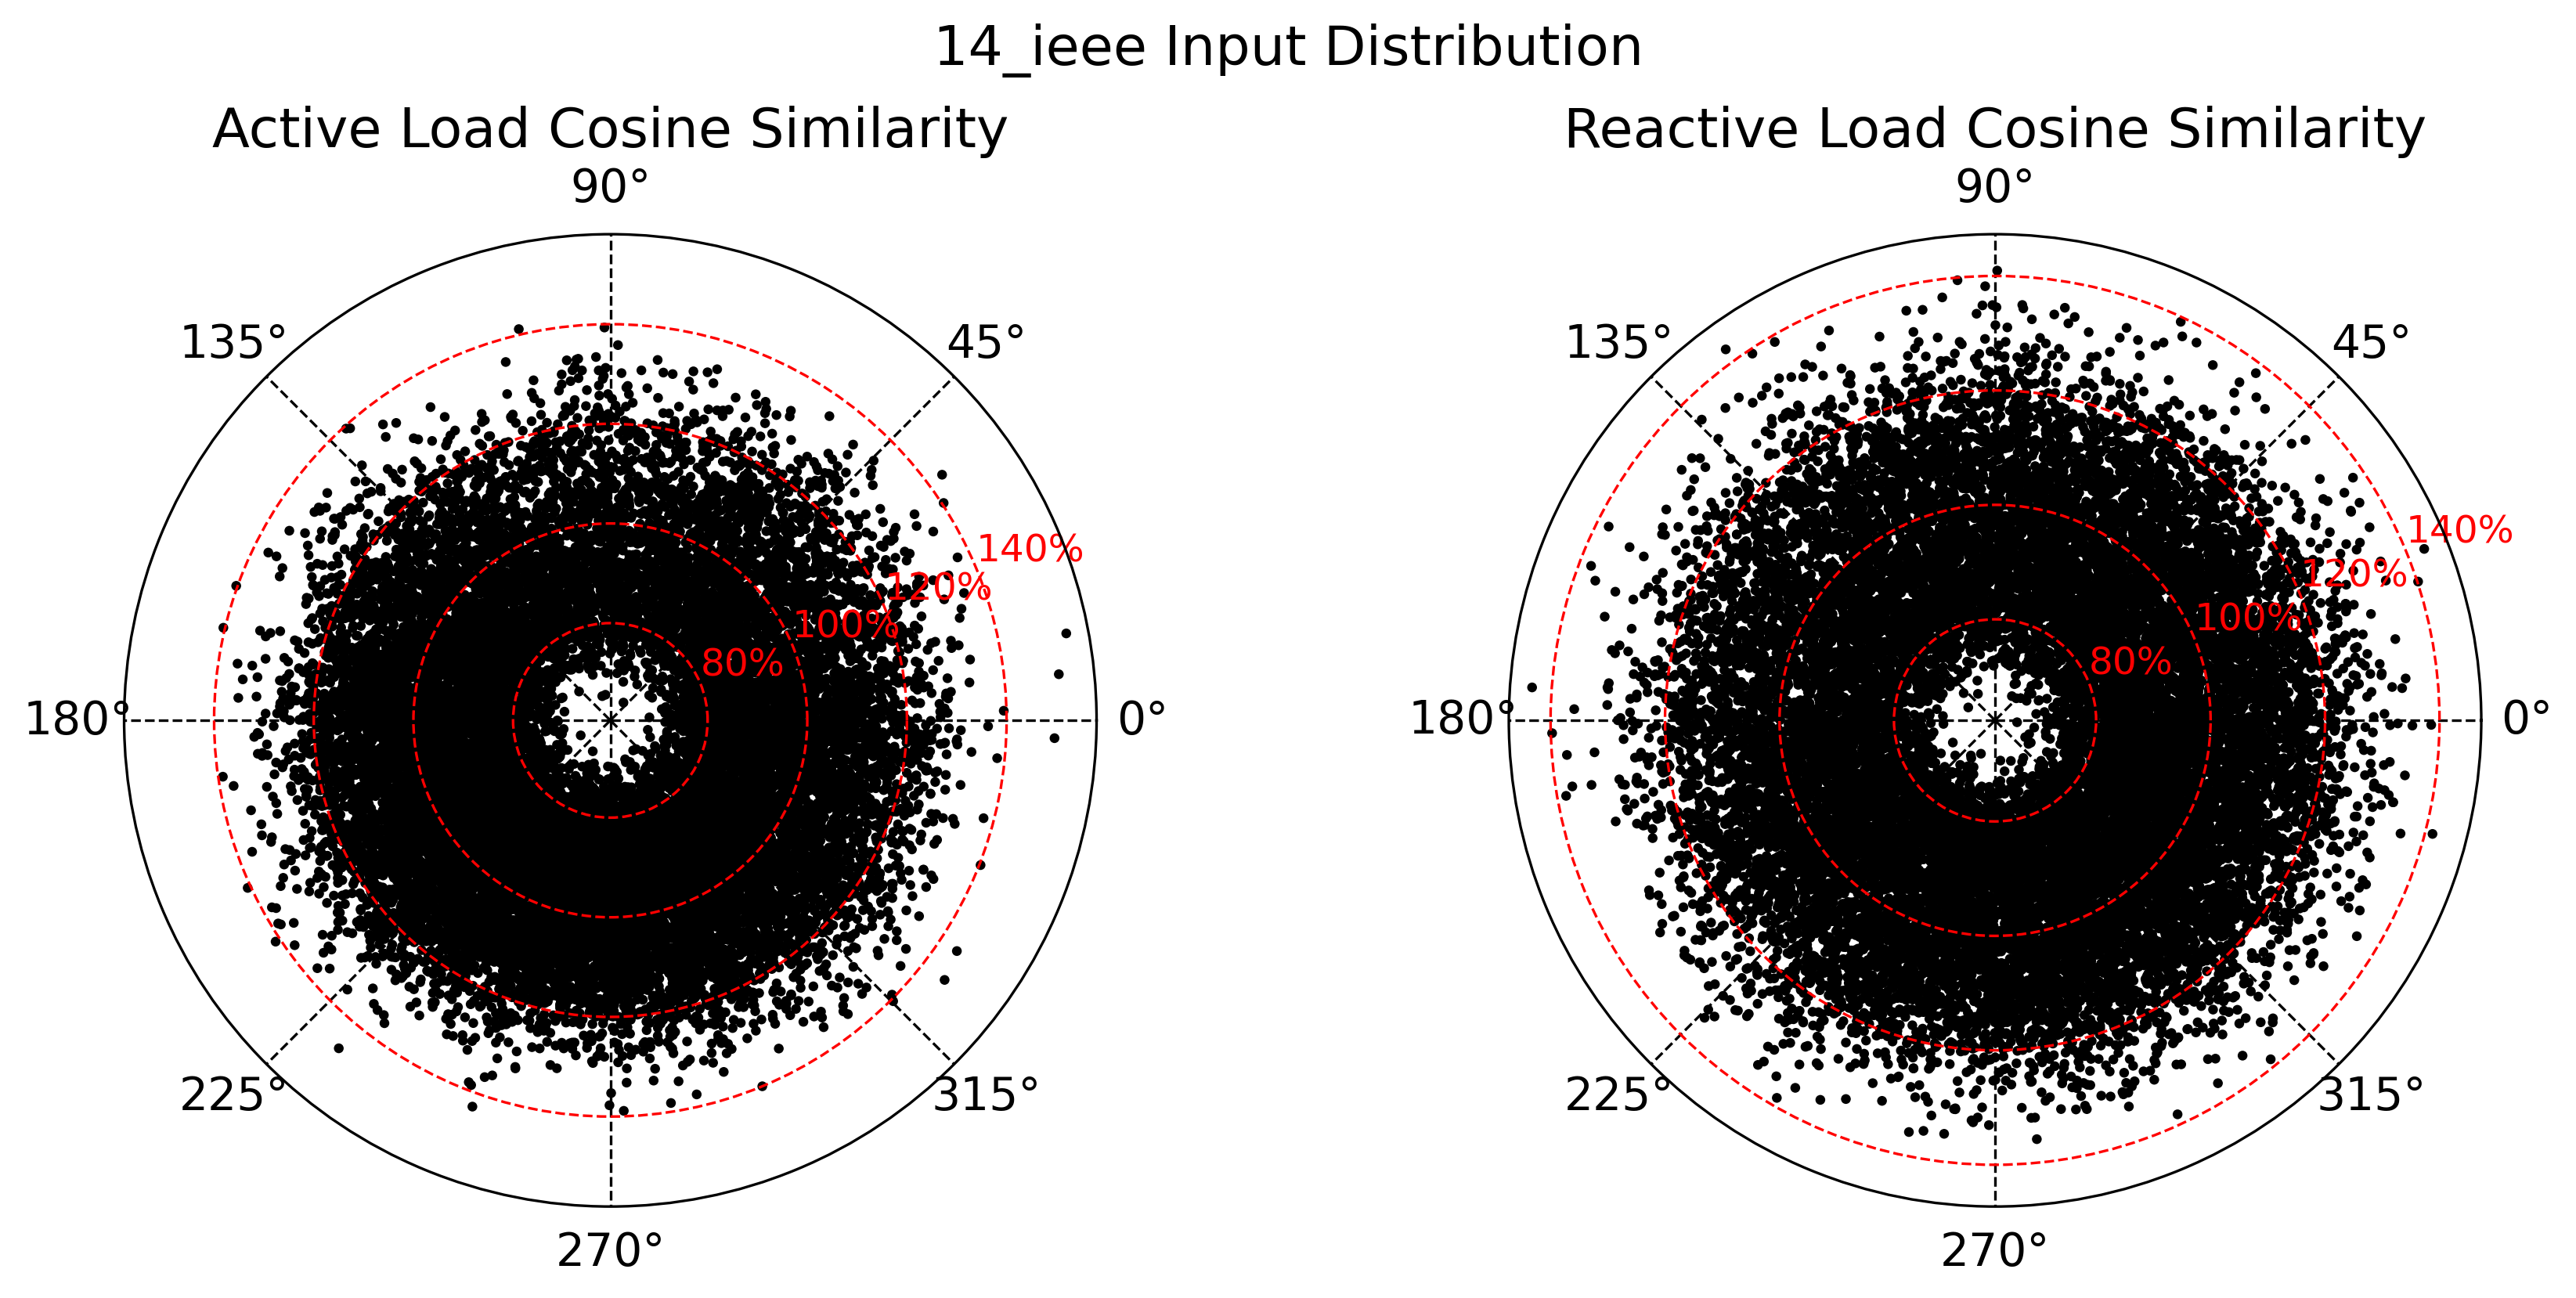

In [22]:
import matplotlib.pyplot as plt, matplotlib.ticker as mtick
import math
from numpy import dot
from numpy.linalg import norm
plt.rc('font', size=14)

def cosine_similarity(A, b):
    return np.array([dot(a, b)/(norm(a)*norm(b)) for a in A])

fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=300, subplot_kw={'projection': 'polar'}, )

for ax, key, name in zip(axs, ["pd", "qd"], ["Active Load", "Reactive Load"]):
    ref_load = ref["load"][key]
    theta = np.arccos(cosine_similarity(D_input["data"][key], ref_load)) * 180 / np.pi
    ax.scatter(
        theta, D_input["data"][key].sum(axis=1) / ref_load.sum(),
        marker='.', edgecolor='none', color='black',
    )
    ax: plt.Axes
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_locator(mtick.MultipleLocator(0.2))
    ax.yaxis.set_tick_params(labelcolor='red', labelsize='small')
    ax.grid(visible=True, which='major', axis='y', color='red', linestyle='--')
    ax.grid(visible=True, which='major', axis='x', color='black', linestyle='--', zorder=0)

    ax.set_title(f"{name} Cosine Similarity")

fig.subplots_adjust(left=0.3, right=0.7)
fig.suptitle(f"{case_ref} Input Distribution", y=1.05)
fig.tight_layout();

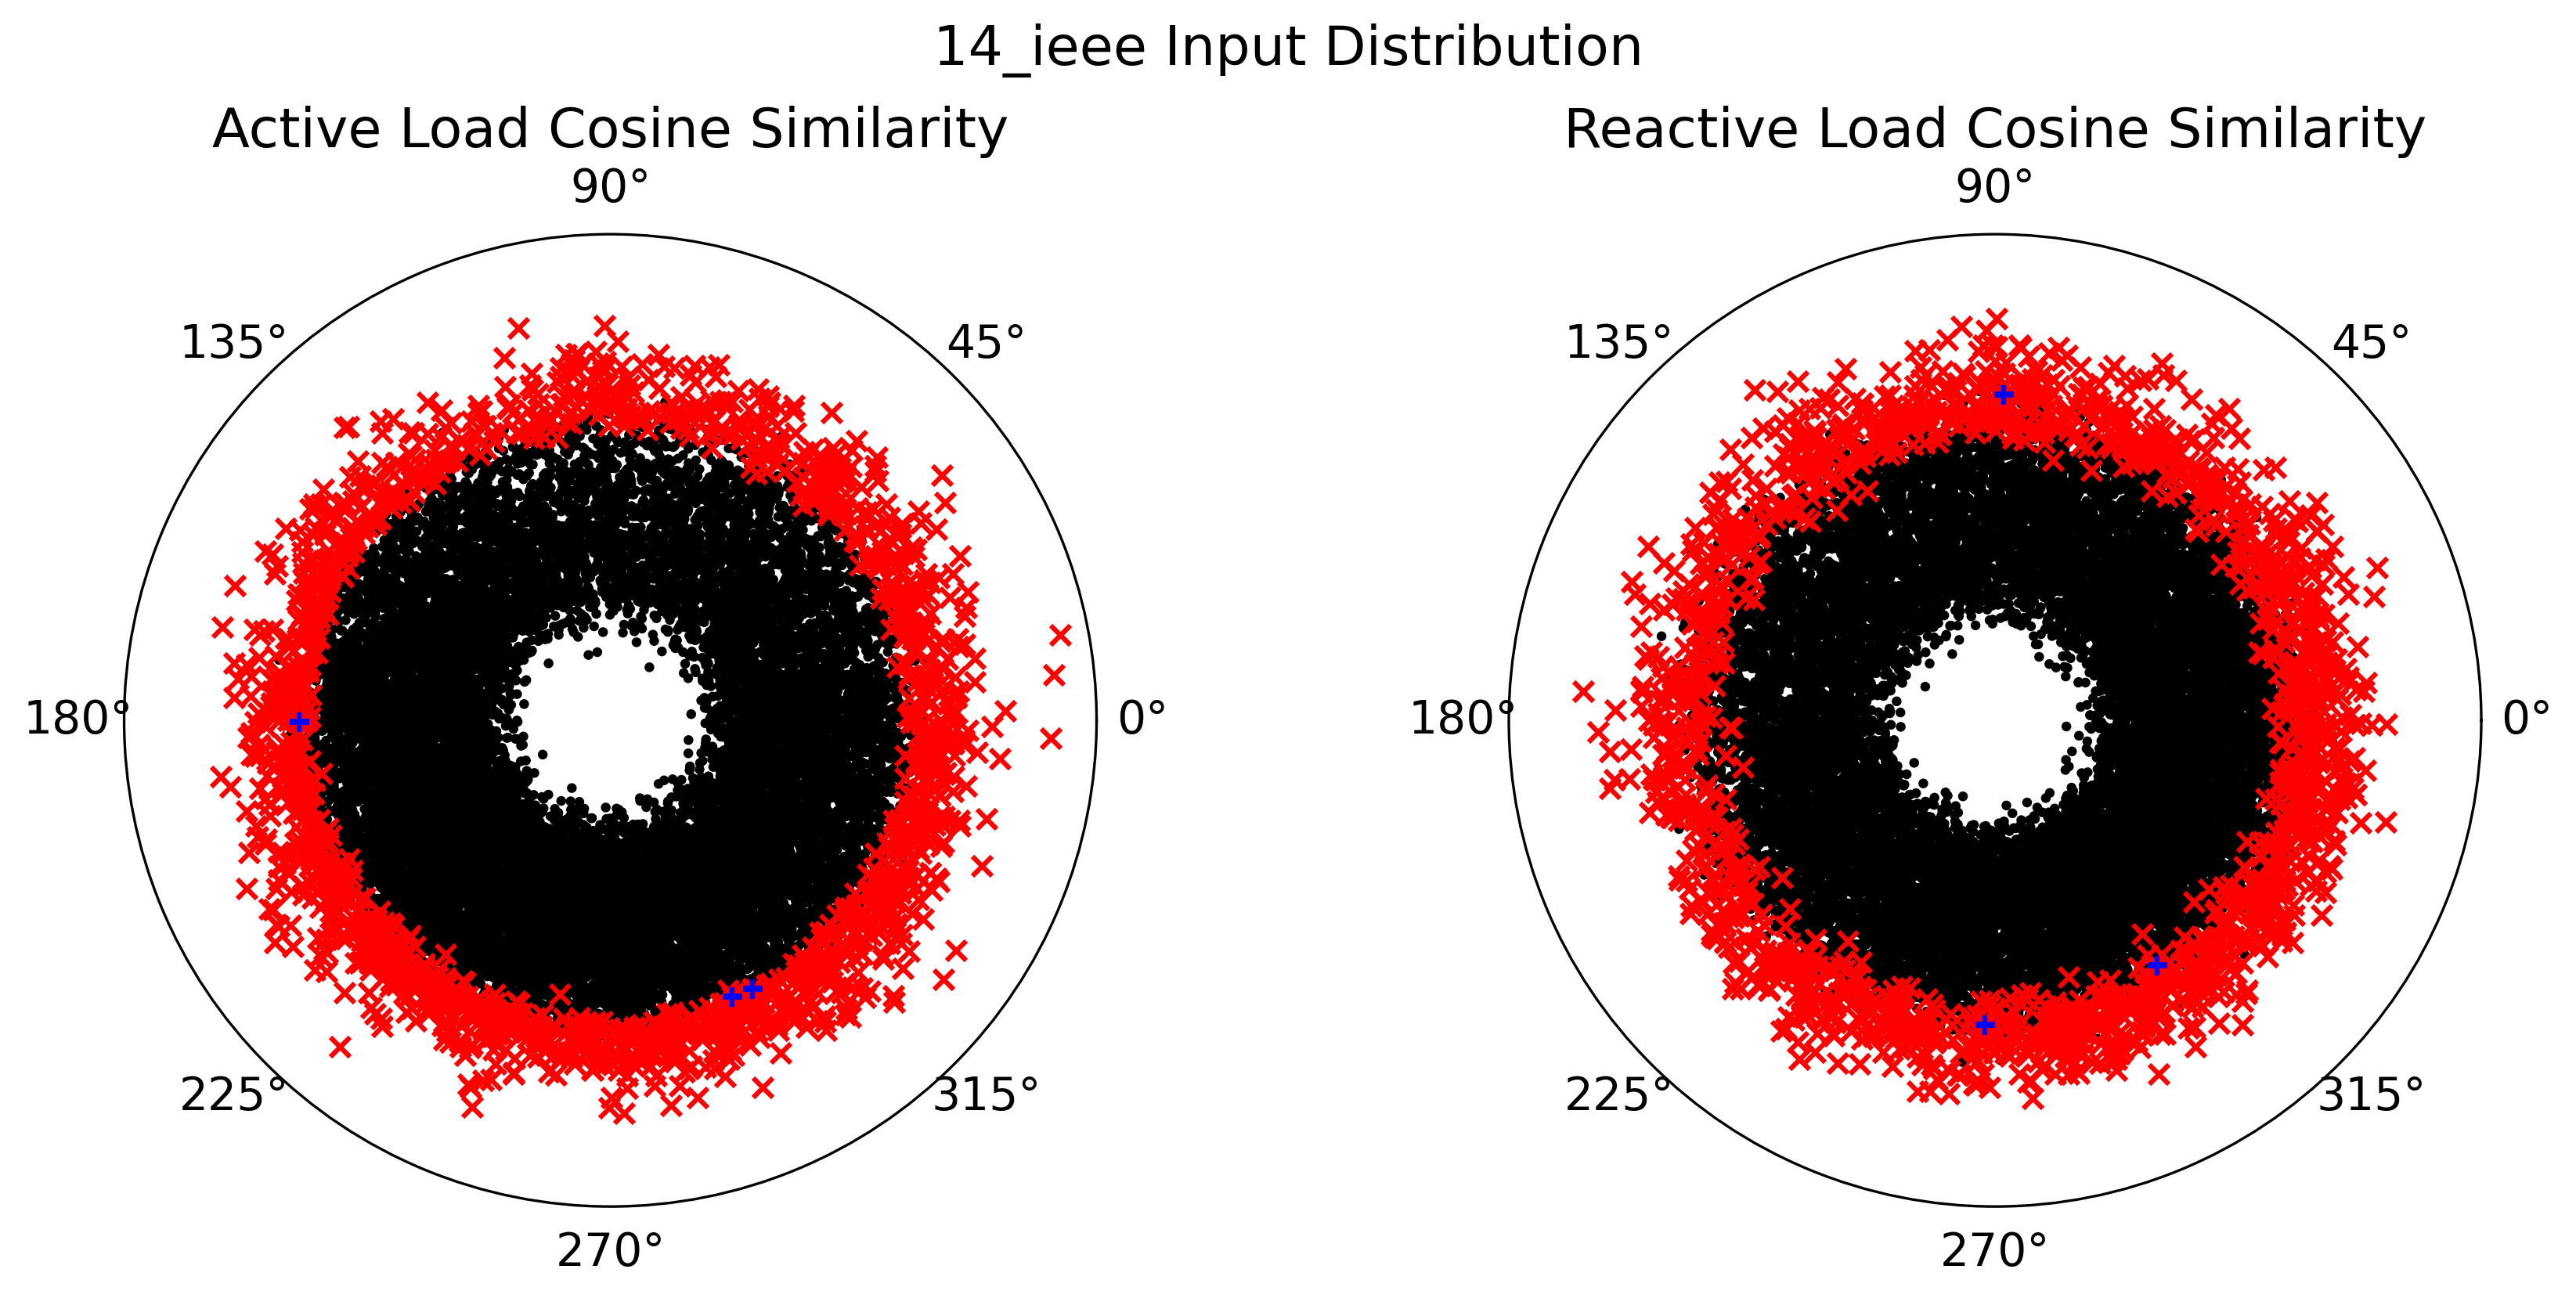

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=300, subplot_kw={'projection': 'polar'}, )

for ax, key, name in zip(axs, ["pd", "qd"], ["Active Load", "Reactive Load"]):
    ref_load = ref["load"][key]
    theta = np.arccos(cosine_similarity(D_input["data"][key], ref_load)) * 180 / np.pi
    ax.scatter(
        theta[all_feasible], D_input["data"][key][all_feasible].sum(axis=1) / ref_load.sum(),
        marker='.', edgecolor='none', color='black',
    )
    ax.scatter(
        theta[ac_infeasible], D_input["data"][key][ac_infeasible].sum(axis=1) / ref_load.sum(),
        marker='x', color='red',
    )
    ax.scatter(
        theta[soc_feasible_ac_infeasible], D_input["data"][key][soc_feasible_ac_infeasible].sum(axis=1) / ref_load.sum(),
        marker='+', color='blue',
    )
    ax.set_yticks([])
    ax.grid(False, axis='x')


    ax.set_title(f"{name} Cosine Similarity")
    ax.set_ylim(0.5, 1.6)
    

fig.subplots_adjust(left=0.3, right=0.7)
fig.suptitle(f"{case_ref} Input Distribution", y=1.05)
fig.tight_layout();

In [24]:
def acp_dcp_soc_fig(total_load, ac_true, dc_true, soc_true, ylabel, name, xmin=None, xmax=None, rows=2):
    """Comparison plot for ACOPF, DCOPF, and SOCWRConic solutions.
    
    Args:
        total_load (np.ndarray): Total load data. (n_samples, 1)
        ac_true (np.ndarray): ACOPF solution. (n_samples, n_components)
        dc_true (np.ndarray): DCOPF solution. (n_samples, n_components)
        soc_true (np.ndarray): SOCWRConic solution. (n_samples, n_components)
        ylabel (str): Y-axis label.
        name (str): Name of the component.
        xmin (np.ndarray, optional): Lower bounds. Defaults to None.
        xmax (np.ndarray, optional): Upper bounds. Defaults to None.
        rows (int, optional): Number of rows of plots. Defaults to 2.
    """
    n_components = ac_true.shape[1]

    cols = math.ceil(n_components / rows)
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 7, 5 * rows), dpi=150)
    axs = axs.flatten()

    for i in range(n_components):
        ax = axs[i]
        if dc_true is not None:
            ax.scatter(total_load[all_feasible], dc_true[all_feasible, i], label="DCOPF", color="black", marker='.')
        if ac_true is not None:
            ax.scatter(total_load[all_feasible], ac_true[all_feasible, i], label="ACOPF", color="red", marker='+')
        if soc_true is not None:
            ax.scatter(total_load[all_feasible], soc_true[all_feasible, i], label="SOCWRConic", color="blue", marker='x')
        ax.set_xlabel("Total Active Load (p.u.)")
        ax.set_ylabel(ylabel)

        if xmin is not None:
            ax.axhline(y=xmin[i], color="black", linestyle="--", label="Bounds")
        if xmax is not None:
            ax.axhline(y=xmax[i], color="black", linestyle="--")

        ax.set_title(f"{name} {i}")
        
    axs[0].legend()
    fig.tight_layout()
    fig.suptitle(f"{case_ref} {name} Comparison", y=1.05)

    return fig, axs

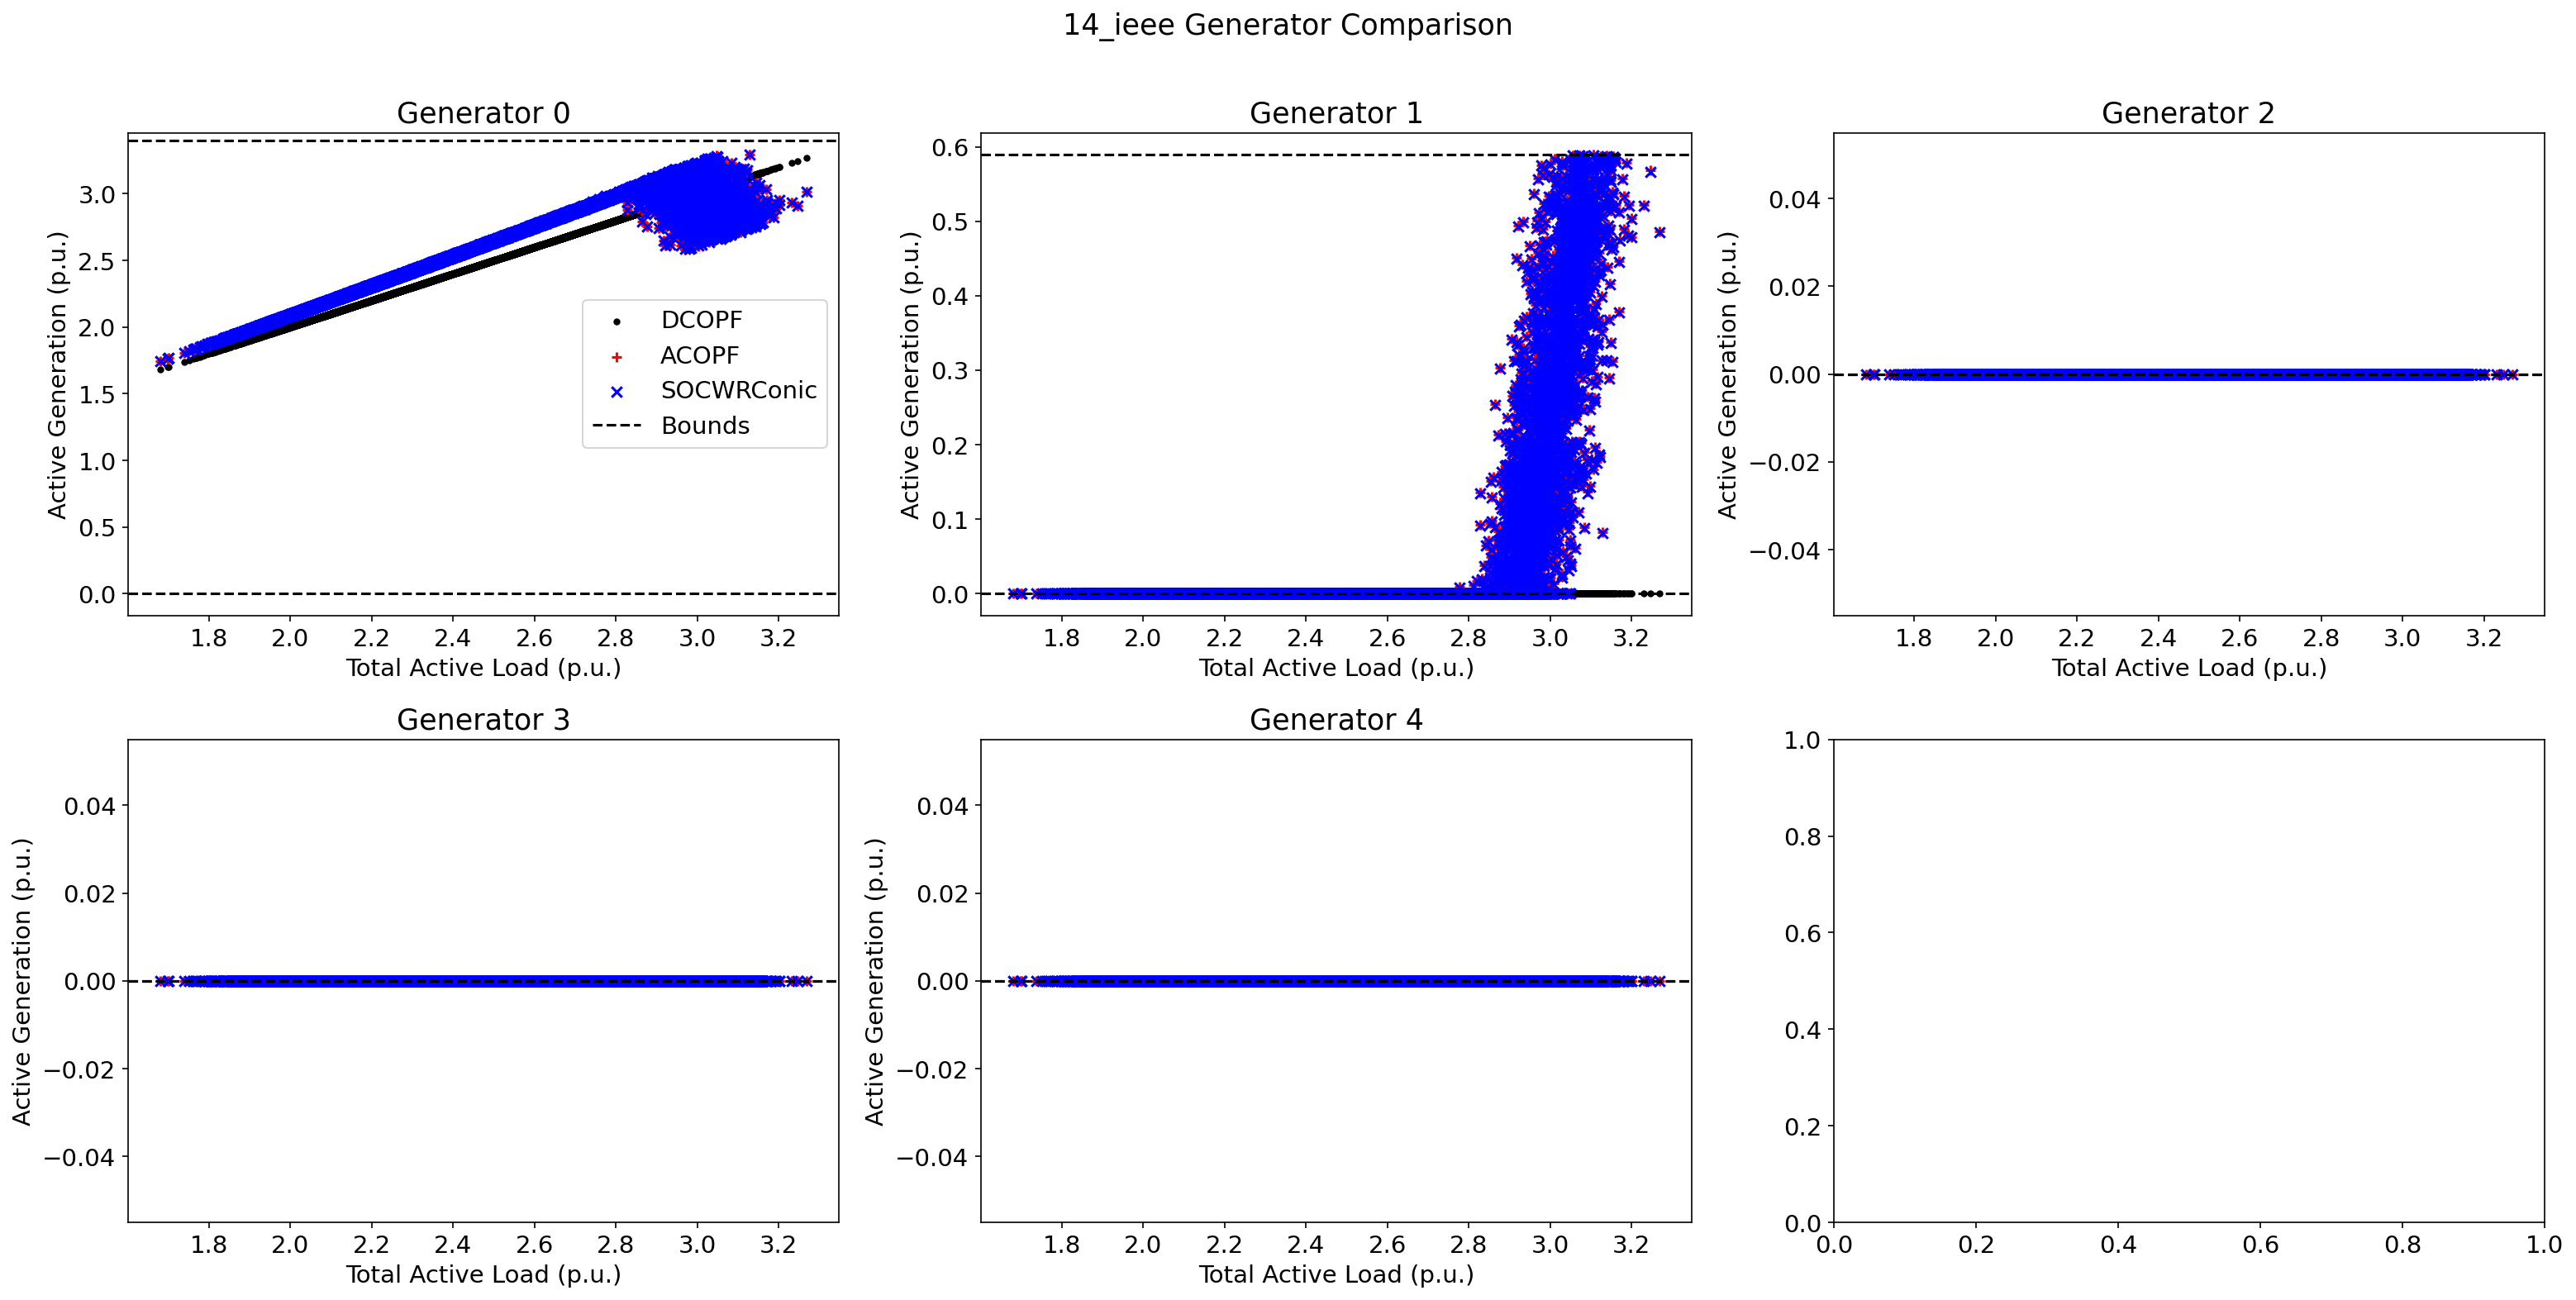

In [25]:
acp_dcp_soc_fig(
    D_input["data"]["pd"].sum(axis=1),
    D_acp["primal"]["pg"],
    D_dcp["primal"]["pg"],
    D_soc["primal"]["pg"],
    "Active Generation (p.u.)",
    "Generator",
    ref["gen"]["pmin"],
    ref["gen"]["pmax"],
    rows=2,
);

### Visualize network

Install `networkx` to visualize the network.

In [26]:
%pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [27]:
# read the json into a networkx graph
import networkx as nx

def make_network(path):
    with open(path, "r") as f:
        raw_json = json.load(f)
        file_data = raw_json["data"]

    G = nx.Graph()

    for bus in sorted(file_data["bus"].keys(), key=int):
        G.add_node(file_data["bus"][bus]["index"], type="bus", **file_data["bus"][bus])

    for branch in sorted(file_data["branch"].keys(), key=int):
        G.add_edge(file_data["branch"][branch]["f_bus"], file_data["branch"][branch]["t_bus"], **file_data["branch"][branch])

    for gen in file_data["gen"]:
        G.nodes[file_data["gen"][gen]["gen_bus"]]["generator"] = file_data["gen"][gen]
        G.nodes[file_data["gen"][gen]["gen_bus"]]["type"] = "generator"
    
    for load in file_data["load"]:
        _type = G.nodes[file_data["load"][load]["load_bus"]]["type"]
        G.nodes[file_data["gen"][gen]["gen_bus"]]["load"] = file_data["load"][load]
        G.nodes[file_data["load"][load]["load_bus"]]["type"] = "load" if _type != "generator" else "generator + load"

    for shunt in file_data["shunt"]:
        G.nodes[file_data["shunt"][shunt]["shunt_bus"]]["shunt"] = file_data["shunt"][shunt]

    return G

G = make_network(data_folder / f"{case_ref}.ref.json")

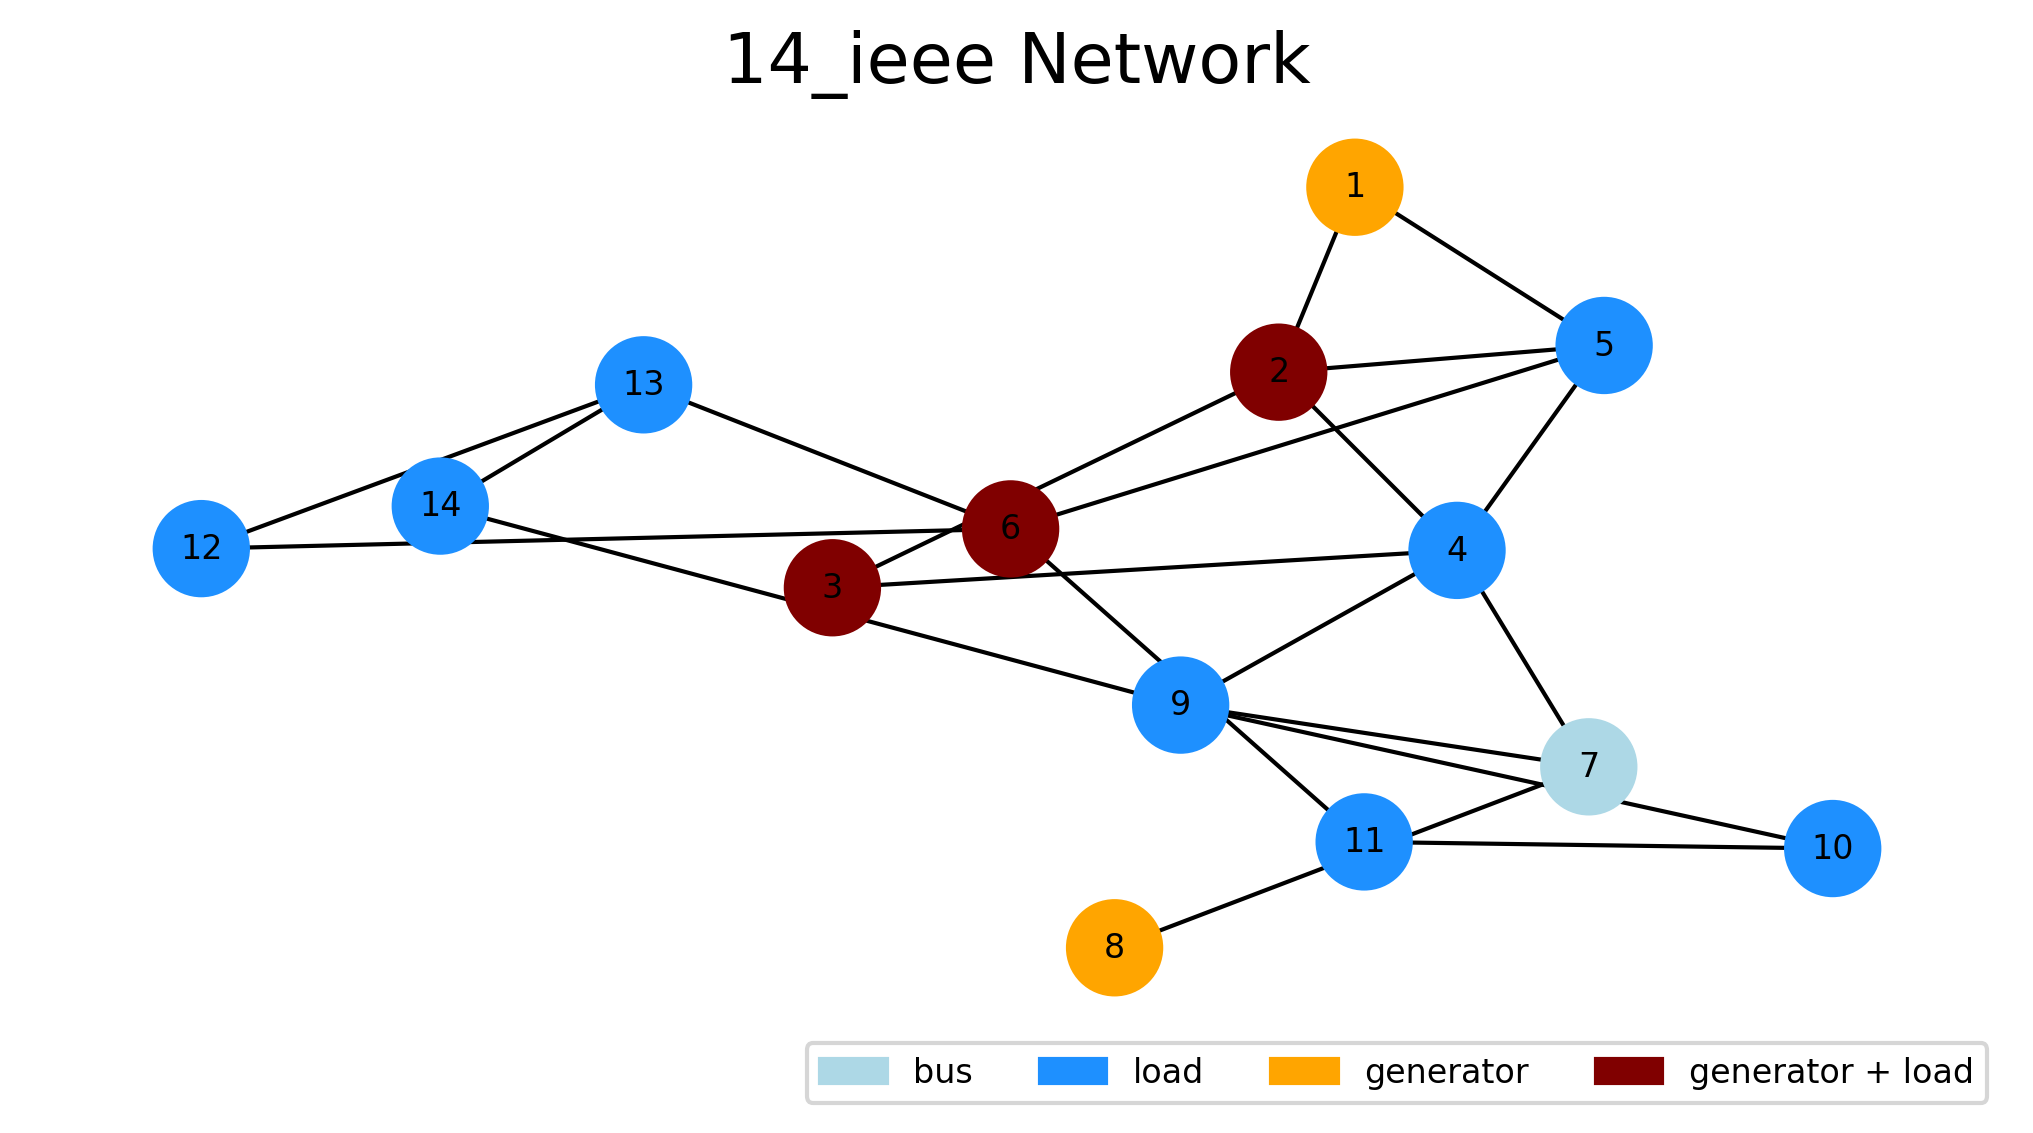

In [28]:
# draw the network
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=300)

node_colors = {
    "bus": "lightblue",
    "load": "dodgerblue",
    "generator": "orange",
    "generator + load": "maroon",
}

nx.draw(
    G=G,
    pos=nx.spring_layout(G, k=1, seed=42),
    ax=ax,
    node_color=[node_colors[G.nodes[n]["type"]] for n in G.nodes],
    with_labels=True,
    node_size=500,
    edge_color="black",
    font_size=8
)

legend_handles = [mpatches.Patch(color=color, label=label) for label, color in node_colors.items()]
leg = ax.legend(handles=legend_handles, loc="lower right", ncol=4, fontsize=8)
leg.set_bbox_to_anchor((1, -0.1))

ax.set_title(f"{case_ref} Network")
fig.tight_layout();